# III_multiple_imaged_case_corrected_lens_model
this notebook is based on lenstronomy version = 1.10.3, lenstruction version = 0.1.0, photutils version = 1.3.0


# Load data
All fits file used in this notebook can be downloads via following links:

cutout_macs0717_f555w.fits: https://drive.google.com/file/d/1gHdSg5YuQoM87Djp_UmdBfQc-U1U8X7w/view?usp=sharing

cutout_gamma1_bradac.fits:  https://drive.google.com/file/d/1GBWVCS3-YjApIVo3wxhTpz1pSZGXLark/view?usp=sharing

cutout_gamma2_bradac.fits: https://drive.google.com/file/d/1OPAArj2j01HbyXpr5zPfwWV1zyiXOxJn/view?usp=sharing

cutout_kappa_bradac.fits: https://drive.google.com/file/d/1wPapVRDJzG60Sai5-KQ_hFr6wigIjf2C/view?usp=sharing

In [1]:
%matplotlib inline 
import numpy as np
from astropy.io import fits

#required input from user , the user need to input:
#1) the observed image data (fits file)
datafits = 'cutout_macs0717_f555w.fits'
dataheader = fits.open(datafits)[0].header
imgdata = fits.open(datafits)[0].data 

#2)deflection maps (fits files)
gamma1_in = fits.open('cutout_gamma1_bradac.fits')[0].data
gamma2_in = fits.open('cutout_gamma2_bradac.fits')[0].data
kappa_in =  fits.open('cutout_kappa_bradac.fits')[0].data

#3)coordinates of lensed images
ra=[109.39854507, 109.394456,109.40716028] #3.1.2.3
dec = [37.741494278, 37.73917, 37.753834592]

#4)redshift of lens and source
zl=0.545
zs = 1.855 

#5) psf coordinate 
ra_psf = 109.3778532
dec_psf =37.75321639


# Initialize DataProcess class 
For multiply-imaged system, we combine multiple images to perform source reconstruction.

Singly-imaged case example can be found in notebook:
* I_single_lensed_image_source_reconstruction

Multiply-imaged case with uncorrected lens model example can be found in notebook:
* II_multiple_imaged_case_uncorrected_lens_model



INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Note: Lenstruction r

        Use `~photutils.segmentation.SourceCatalog` instead. [lenstruction.data_process]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]
/Users/lilan/lensphysics/lenstruction_forgithub/lenstruction/lenstruction/data_process.py:541: RuntimeWarning: invalid value encountered in log10
  ax5.imshow(np.log10(psf), origin='lower', cmap="gist_heat")


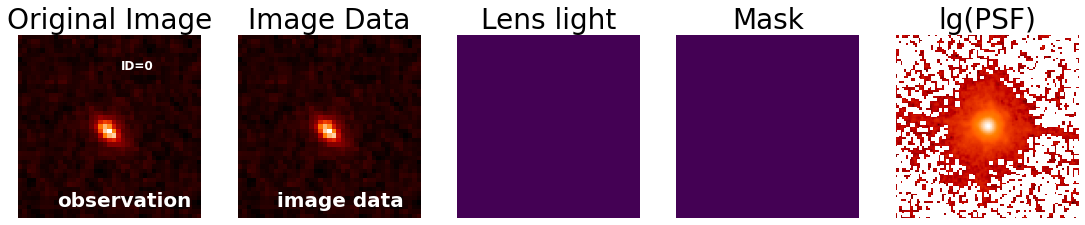

        Use `~photutils.segmentation.SourceCatalog` instead. [lenstruction.data_process]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]
/Users/lilan/lensphysics/lenstruction_forgithub/lenstruction/lenstruction/data_process.py:541: RuntimeWarning: invalid value encountered in log10
  ax5.imshow(np.log10(psf), origin='lower', cmap="gist_heat")


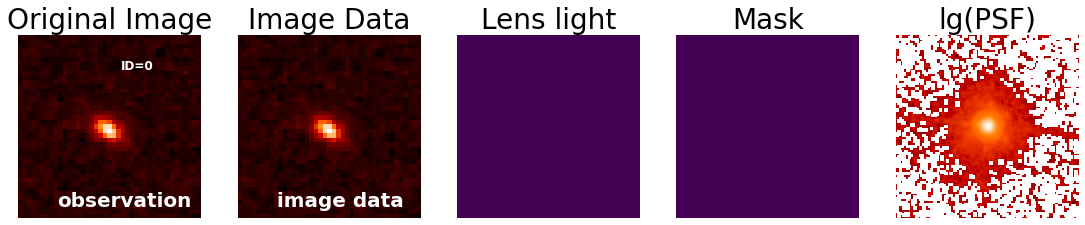

        Use `~photutils.segmentation.SourceCatalog` instead. [lenstruction.data_process]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]
/Users/lilan/lensphysics/lenstruction_forgithub/lenstruction/lenstruction/data_process.py:541: RuntimeWarning: invalid value encountered in log10
  ax5.imshow(np.log10(psf), origin='lower', cmap="gist_heat")


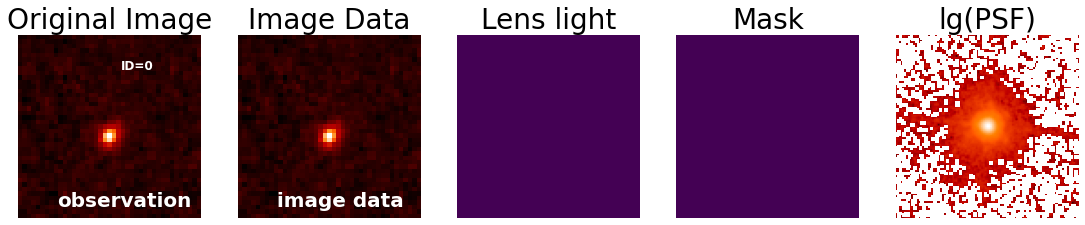

In [2]:
#import DataProcess class
from lenstruction.data_process import DataProcess
#initilize DataProcess
datapreparation = DataProcess(image_data=imgdata, header=dataheader,snr=3.0,npixels=20, deltaPix=0.03, interaction=False) 
#snr: SNR for source detection, npixels: number of connected pixel for a source
#deltaPix:  pixel size of the fits files
#interaction: False or True, user interaction 

#coordinates of lensed images in pixel, keywords arguments of data and psf in lenstronomy convention
ximg_list, yimg_list,xylenslight,kwargs_data_joint= datapreparation.params(ra =ra, dec = dec, ra_psf =ra_psf, 
                                                               dec_psf = dec_psf, r_cut=20, 
                                                               add_mask=5, img_name='multiple-corrected')
#r_cut: cut radius of data
#add_mask: addtional pixels around selected segmatations


#pixel scale in image plane, reader from fits header or input from user
deltapix = datapreparation.deltaPix

# Initialize LensSpecify class 

For multiply-imaged system, observed multiple images provide information to constrain the relative lensing operator.
The initial lens model is not sufficiently accurate in their relative lensing operators to accurately predict good models to the pixel level for all images simultaneously and needs correction as expected.
As shown in notebook:
* II_multiple_imaged_case_uncorrected_lens_model

As only relative lens parameters can be constrained, letting all lensing operators free will unavoidably lead to an underconstraint problem with degeneracies. To avoid this in finding a solution and the sampling, we fix the lens parameters of one image.

Same as singly-imaged case, the morphologies of the observed images are compact, 
thus we just apply the lowest lens model complexity, $\textbf{shear}$ and $\textbf{convergence}$.
We obtain lens parameters from shear (gamma1, gamma2) and convergence (kappa) maps directly.
(See section 4.2.1 in Yang et al. 2020 for more details.)

In [3]:
#import LensSpecify class 
from lenstruction.lens_specify import LensSpecify
#initilize parameters for lens model with lens model maps, lens and source redshift
header = fits.open('cutout_gamma1_bradac.fits')
lenspre = LensSpecify(zl=zl,zs=zs, xdeflection=None, ydeflection=None, gamma1=gamma1_in, gamma2=gamma2_in,
                       kappa=kappa_in, hdul = header)

#expand the initial lens model as lenstronomy acceptable convention
lens_params=lenspre.params(ximg_list=ximg_list, yimg_list=yimg_list, ra_list = ra, dec_list = dec , 
                            kwargs_data_joint=kwargs_data_joint)

# lens model consist of several profiles, corresponding index of parameters in each profile 
lens_model_list = lenspre.model_index_list() 
#Note, although model list contains 'FLEXIONFG', flexion terms non-activated defaultly




INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


### Fix the lens model parameters of the least magnified image
We fix all lens model parameters as its initilization.
$\textbf{lens_params}$ is a list consist of initial value, sigma, fixed value during follwing modeling, lower and upper boundary [kwargs_lens_init, kwargs_lens_sigma, kwargs_fixed_lens, kwargs_lower_lens, kwargs_upper_lens] 


In [5]:
# the least magnified image
mag_min_index = lenspre.fixed_index

# Initialize SourceSpecify class 
The morphologies of the observed images are compact, 
thus we just apply the lowest source light model complexity, an elliptical $\textbf{Sersic}$ profile for source,

In [8]:
#import SourceSpecify class 
from lenstruction.source_specify import  SourceSpecify
#initilize parameters for source light model with profile name
sourcepreparation=SourceSpecify()#default light model is sersic

#source_model_list
source_model_list= sourcepreparation.model_list()
#Note: default value of n_max in 'SHAPELETS' is '-1' that means shapelets model is nonactivated


#betax, betay and deltaPix, center position in source plane, pixel scale in the source plane
source_params = sourcepreparation.params()


from lenstruction.lenslight_specify import LenslightSpecify
#lenslight model
lenslightpre =  LenslightSpecify(xcenter = xylenslight[0], ycenter=xylenslight[1])      
lenslight_params = lenslightpre.params()

$\textbf{source_params}$ is a list consist of initial value, sigma, fixed value during follwing modeling, lower and upper boundary
[kwargs_source_init, kwargs_source_sigma, kwargs_fixed_source, kwargs_lower_source, kwargs_upper_source]


# Modeling procedures 
$ClsrWorkflow$ is used to manage modeling while all the ingredients for modeling are ready, 
The source light model set up in previous step, and lens model parameter also seleted. 

In [9]:
#import ClsrWorkflow class 
from lenstruction.clsr_workflow import ClsrWorkflow
#itilize ClsrWorkflow class, with data, models configuration, lens model parameters, source model parameters

#1.Constrain on fitting format     
lens_model_list = lenspre.model_index_list()
source_model_list= sourcepreparation.model_list()
lenslight_model_list=lenslightpre.model_list()
kwargs_model ={} 
kwargs_model.update(source_model_list)
kwargs_model.update(lens_model_list)
kwargs_model.update(lenslight_model_list)

#2.addtional constrain
source_constrain = sourcepreparation.constrain(source_constrain={'joint_source_with_source': [[0, 1, ['center_x', 'center_y']]]})
kwargs_constraints = source_constrain
plu_mask_out_list = datapreparation.plu_mask_out_list
kwargs_likelihood = {'image_likelihood_mask_list': plu_mask_out_list}



#pass all the prepared materials into ClsrWorkflow class
clsr_wf = ClsrWorkflow(kwargs_data_joint=kwargs_data_joint, 
                        lens_params=lens_params,
                        source_params=source_params,
                        lenslight_params=lenslight_params,
                        kwargs_model=kwargs_model,
                        kwargs_constraints=kwargs_constraints, 
                        kwargs_likelihood = kwargs_likelihood)


#Run PSO to get the best-fitting results
chain_list_lens, kwargs_results_lens,bic_lens = clsr_wf.lensmodel_comp(sigma_scale=.1, n_particles=100, n_iterations=500, 
                                                                       num_img=3, num_lens_model=4, flexion_option=False)

#sigma_scale,n_particles,n_iterations: sigma, numbers of particles, number of iteractions of PSO process
#num_img: numbers of image
#num_lens_model: numbers of lens models
#flexion_option: False/True, using higher order flexion for lens model or not


lens model keep fixed in frame: 0
flexion_fixed: [['update_settings', {'lens_add_fixed': [[7, ['G1', 'G2', 'F1', 'F2'], [0, 0, 0, 0]], [11, ['G1', 'G2', 'F1', 'F2'], [0, 0, 0, 0]]]}]]
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
Converged after 177 iterations!
Best fit found:  -2711.0119757905222 [0.231642057303208, -0.38196015526866806, 0.9347099652360982, 0.11871613677793323, -0.050300068371666076, 0.5471954909503071, 0.016989867021757928, 1.2696096770019885, 0.19255366206671107, -0.2288255223648448, -0.017858595715154923, -0.038093469754876305]
-1.0783659410463493 reduced X^2 of best position
-2711.0119757905222 logL
5028.0 effective number of data points
[{'alpha_x': 61.68, 'alpha_y': 67.19999999999999}, {'gamma1': 0.231642057303208, 'gamma2': -0.38196015526866806, 'ra_0': 61.68, 'dec_0': 67.19999999999999}, {'kappa': 0.9347099652360982, 'ra_0': 61.68, 'dec_0': 67.19999999999999}, {'F1': 0, 'F2': 0, 'G1': 0, 'G2': 0, 'ra_0': 61.68, 'dec_0': 67.19

# Results
$ClsrAnalysis$ class take care of presenting results.

Information of reconstructed source is contained in $\textbf{kwargs_results_lens}$.
(Fig 7 in Yang et al. 2020.)

(-1.2058183798251469, 'reduced X^2 of all evaluated imaging data combined.')
('reduced chi^2 of data ', 0, '= ', 1.1105028987804804)
('reduced chi^2 of data ', 1, '= ', 1.1287749551720234)
('reduced chi^2 of data ', 2, '= ', 1.2824412988219234)


/Users/lilan/lensphysics/lenstronomy_lilan/lenstronomy/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/lilan/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


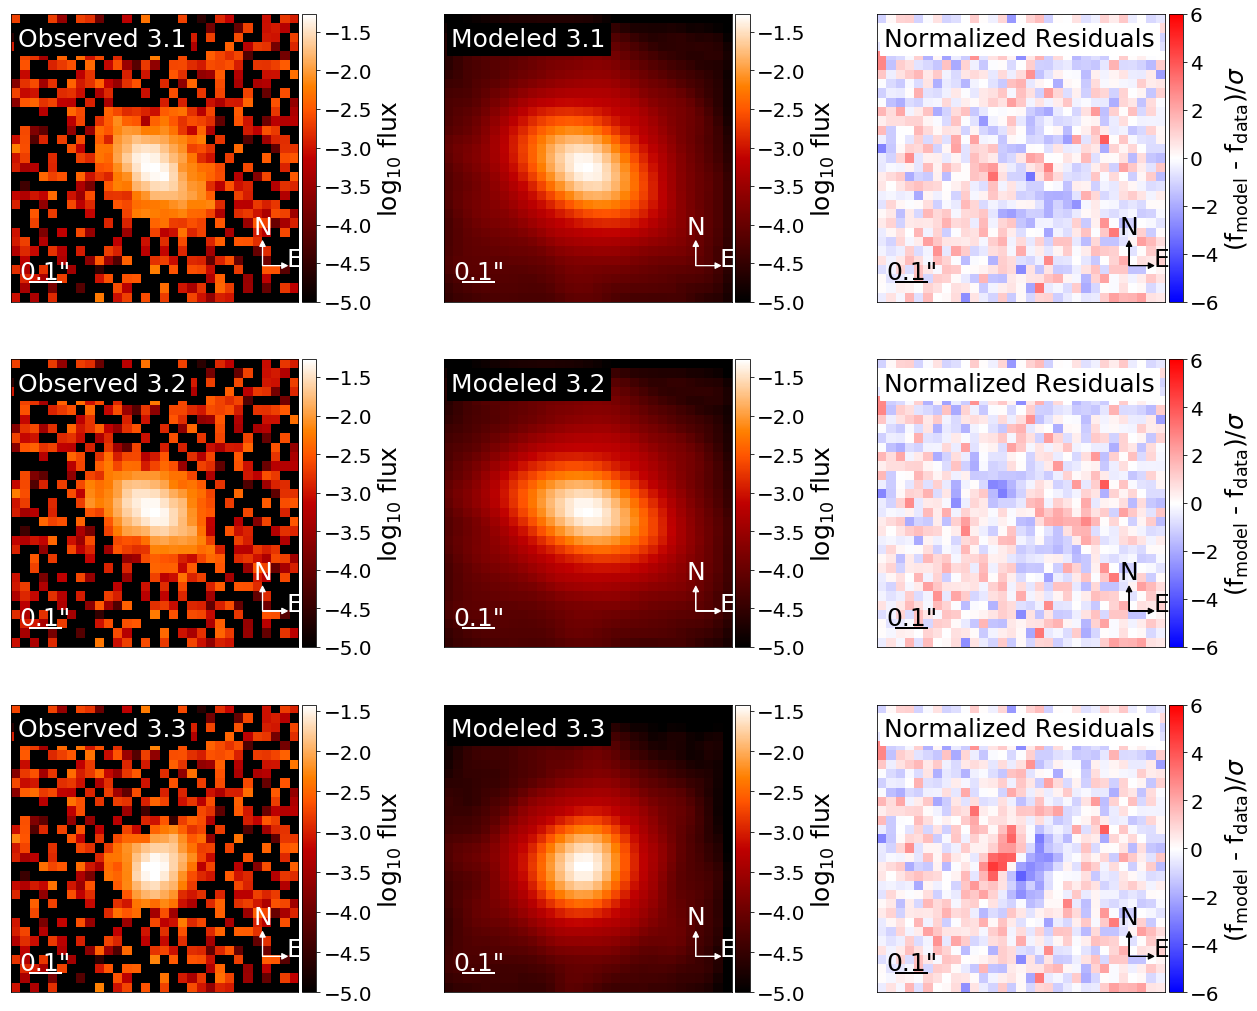

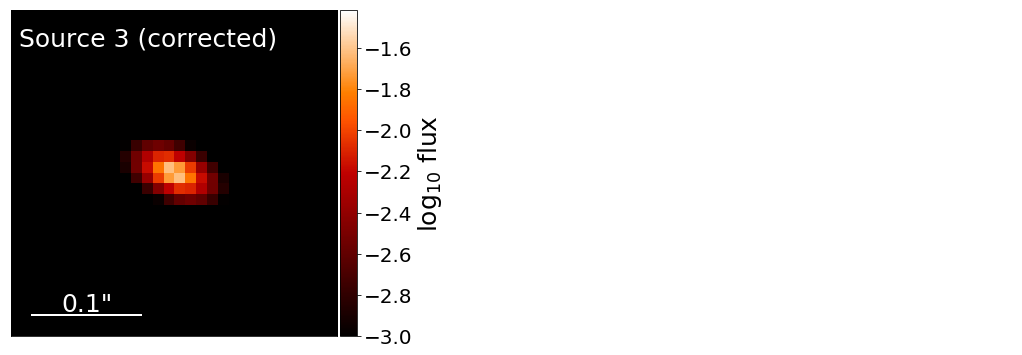

In [7]:
from lenstruction.clsr_analysis import ClsrAnalysis

#plot modeling  procedure 
clsr_anlysis= ClsrAnalysis( kwargs_data_joint, kwargs_model)
clsr_anlysis.plot_modeling(kwargs_result=kwargs_results_lens[0], 
                           deltaPix_s=0.01, numPix_s= 30,font_size=25,
                           text=' 3.',data_index =0,  text_source = ' 3 (corrected)',
                           img_name = 'bradac_3corrected_')
#flux, and effective radius
flux, rh = clsr_anlysis.source_flux_rh(kwargs_results_lens[-1], 0.001,200)

# MCMC
MCMC explores the full posterior and provide the confidence intervals as well as degeneracies between parameters (Figure 9 in Yang et al.2020).

In [8]:
fitting_kwargs_list = [['MCMC', {'n_burn': 300, 'n_run': 50, 'walkerRatio': 10, 'sigma_scale': .1}]]
bic_model_mcmc,chain_list_mcmc, kwargs_result_mcmc = clsr_wf.run_fit_sequence(fitting_kwargs_list)

Computing the MCMC...
('Number of walkers = ', 120)
('Burn-in iterations: ', 300)
('Sampling iterations:', 50)
(132.76980018615723, 'time taken for MCMC sampling')
number of the free model parameters: 13.0
number of the data points: 2883


number of non-linear parameters in the MCMC process:  12
parameters in order:  ['gamma1_lens1', 'gamma2_lens1', 'kappa_ext_lens2', 'gamma1_lens5', 'gamma2_lens5', 'kappa_ext_lens6', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0']
number of evaluations in the MCMC process:  6000


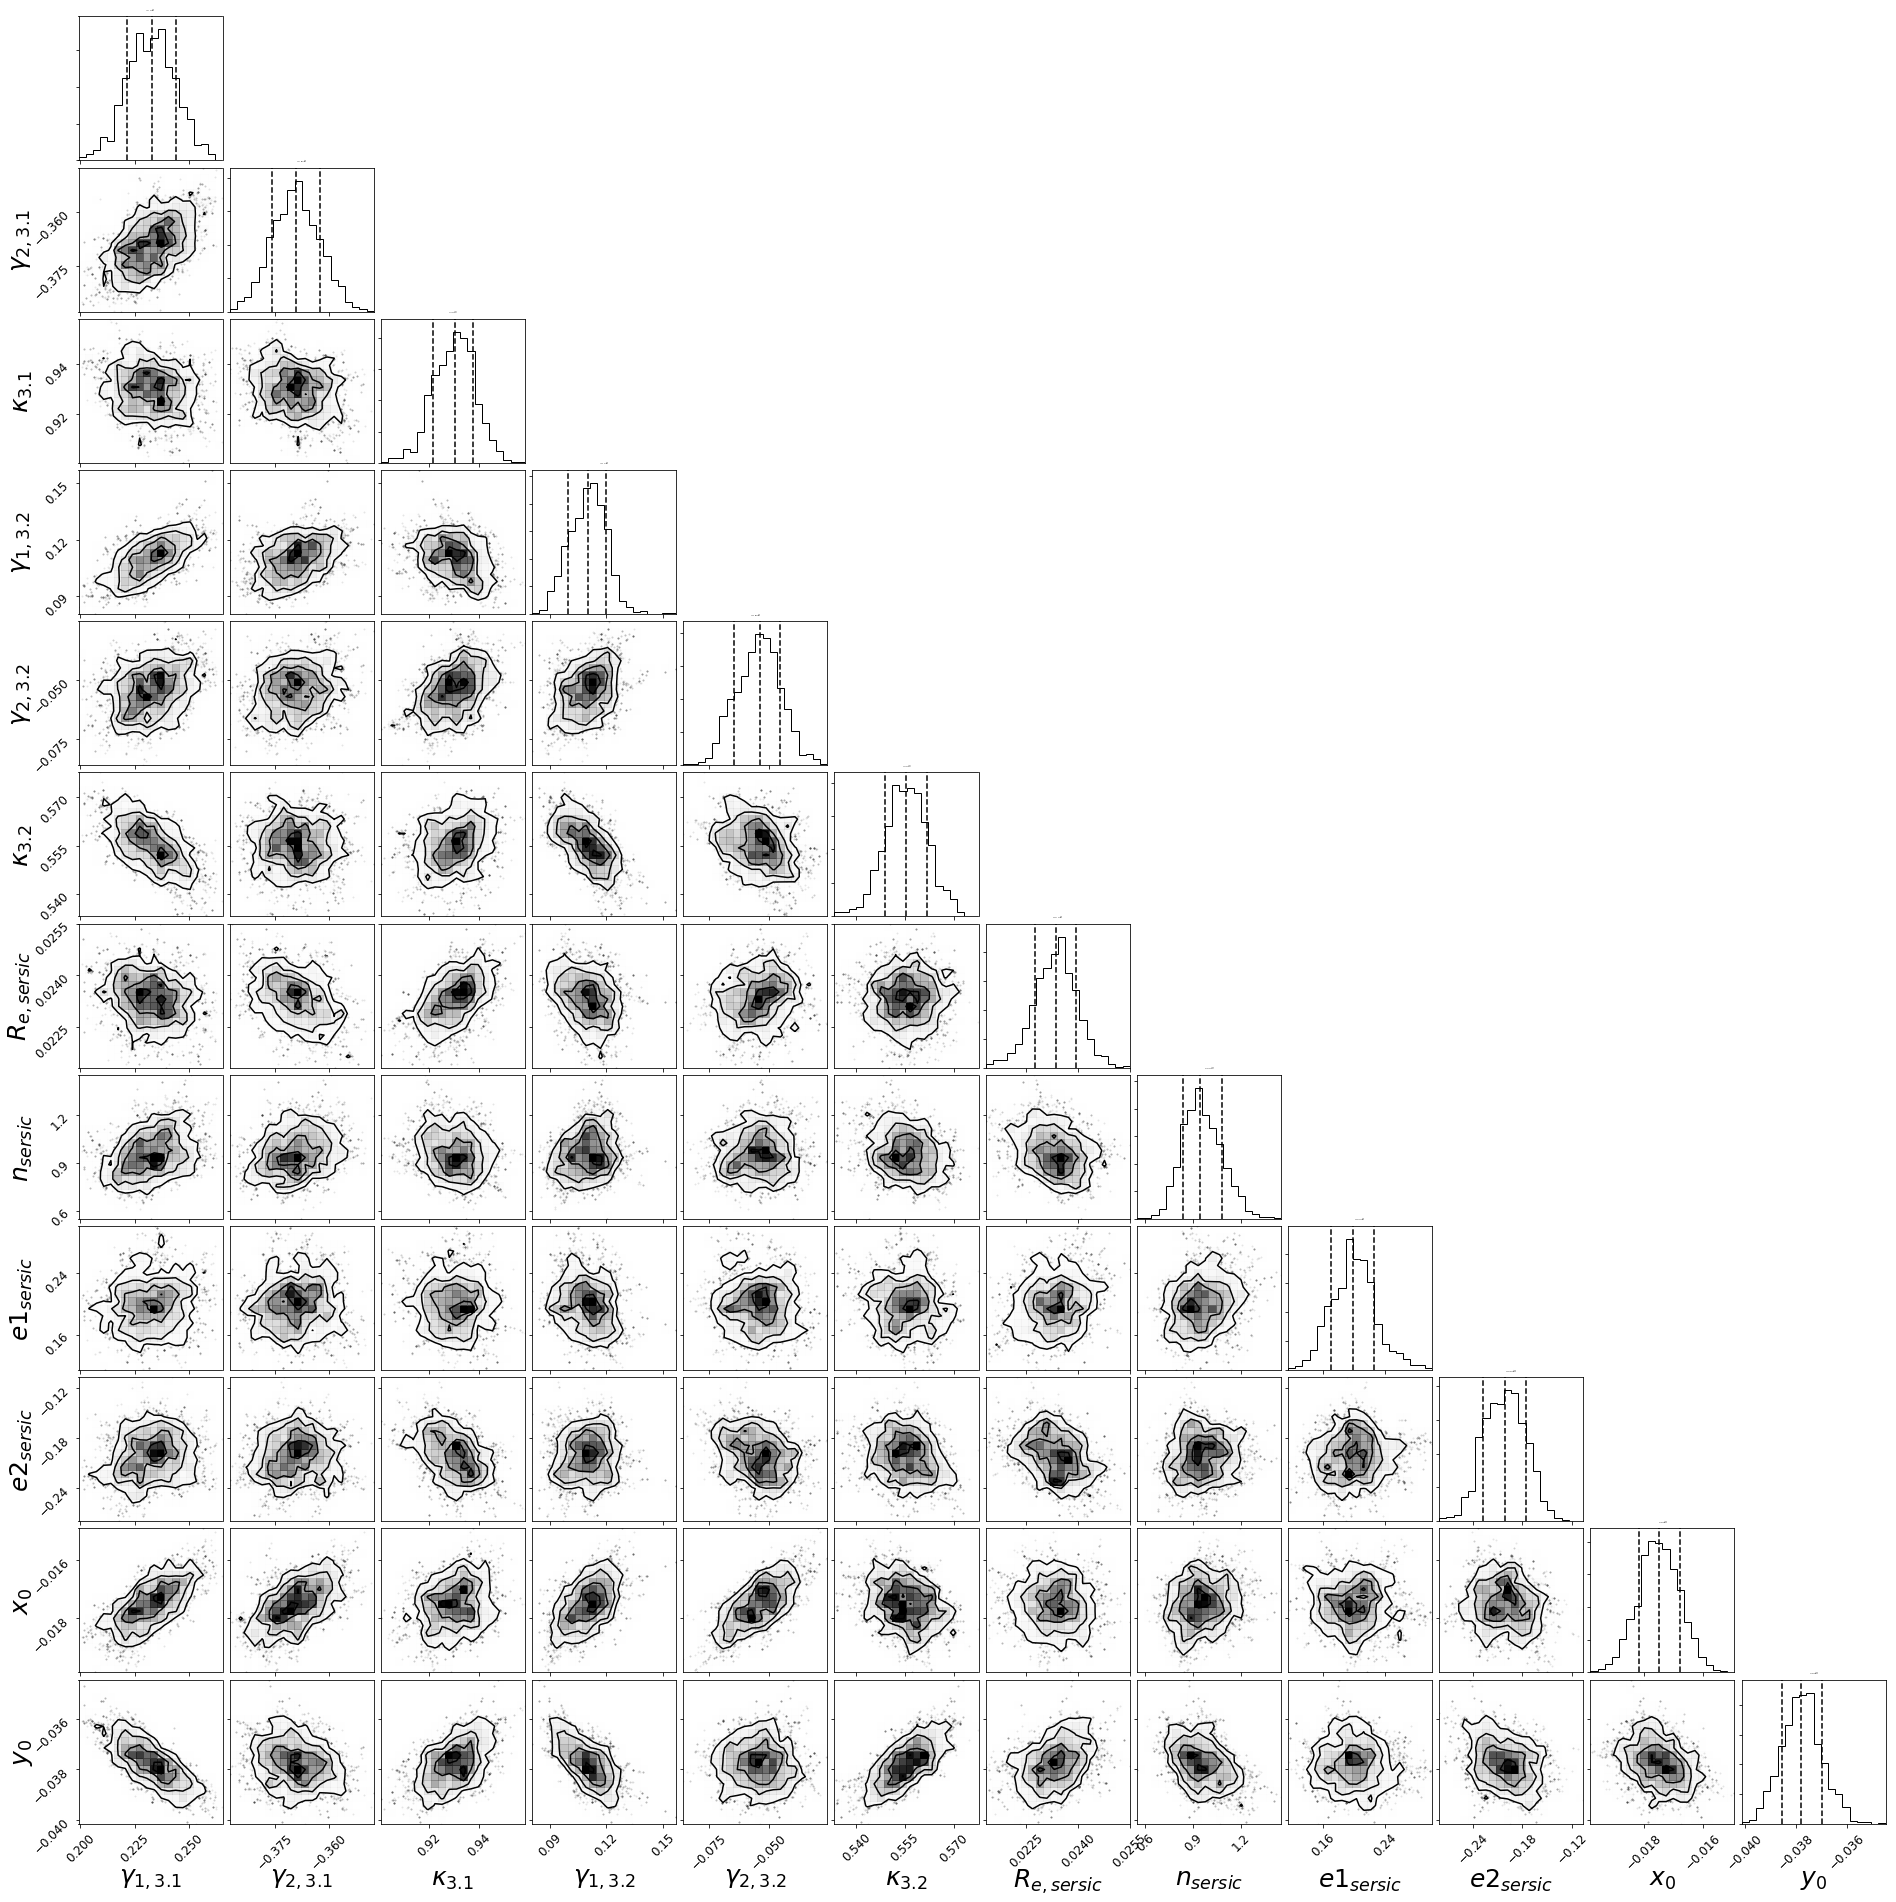

In [9]:
from lenstruction.clsr_analysis import plot_mcmc

parameter_names=[r'$\gamma_{1,3.1}$',r'$\gamma_{2,3.1}$',r'$\kappa_{3.1}$',
 r'$\gamma_{1,3.2}$',r'$\gamma_{2,3.2}$',r'$\kappa_{3.2}$',
 r'$R_{e,sersic}$', r'$n_{sersic}$', r'$e1_{sersic}$',r'$e2_{sersic}$',r'$x_{0}$',r'$y_{0}$' ]

plot_mcmc(chain_list_mcmc, labels=parameter_names)